# 오디오 분류(Audio Classification)

* 가상 악기를 활용해 악기별 음색 데이터셋을 활용해 오디오 분류

1. 기존 데이터에서 분류에 사용되는 방법을 사용해 분류

 1)  wav 파일을 logistic regression, SVM, decision tree 로 분류

 2) 주파수 대역의 Constant-Q 변환(spectrogram 출력) 후
  -  1)의 방법으로 분류
  -  DNN 으로 분류
  -  CNN 으로 분류
2. 오디오 데이터에 특화된 분류
  - MFCC (Mel-frequency cepstral coefficients) 로 반복

* 출처: https://bab2min.tistory.com/642

### 데이터 준비 및 전처리

In [147]:
import numpy as np
import itertools
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

* 데이터를 저장할 리스트와 파일을 불러올 경로를 지정

* https://s3.ap-northeast-2.amazonaws.com/suanlab.com/dataset/GeneralMidi.wav



In [148]:
!wget https://www.dropbox.com/s/3dsnj5ldtf3dcx4/GeneralMidi.wav


--2021-09-16 06:12:04--  https://www.dropbox.com/s/3dsnj5ldtf3dcx4/GeneralMidi.wav
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3dsnj5ldtf3dcx4/GeneralMidi.wav [following]
--2021-09-16 06:12:05--  https://www.dropbox.com/s/raw/3dsnj5ldtf3dcx4/GeneralMidi.wav
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7c5f9ea98caa8ef8f162e428ee.dl.dropboxusercontent.com/cd/0/inline/BWT63Tj3CDoU1uWAb_w-ZUK3yg5viZCGhQ5YdviJOJQDt1_znFwVYjvDCSeVrl721ZT1ahixsiYSdu0l8GGYO5Jl2O0JufyQdbOABriosgHxvESAtlRIzfcQtVU27jIeL4M5qKBPuP44yxEhw3utnGgC/file# [following]
--2021-09-16 06:12:05--  https://uc7c5f9ea98caa8ef8f162e428ee.dl.dropboxusercontent.com/cd/0/inline/BWT63Tj3CDoU1uWAb_w-ZUK3yg5viZCGhQ5YdviJOJQDt1_znFwVYjvDCSeVrl721ZT1ahixsiYSdu0l8

In [149]:
midi_file = "./GeneralMidi.wav"

In [150]:
instruments = [0,10,20,30,40,50,60,70,80,90]
num_notes = 50
sec = 2

audio, inst = [], []
for inst_idx, note in itertools.product(range(len(instruments)), range(num_notes)):
  instrument = instruments[inst_idx]
  offset = (instrument*num_notes*sec) + (note*sec)
  print(f'instrument : {instrument}, note : {note}, offset = {offset}')
  y, sr = librosa.load(midi_file, sr=None, offset=offset, duration = 2.0)
  audio.append(y)
  inst.append(inst_idx)


instrument : 0, note : 0, offset = 0
instrument : 0, note : 1, offset = 2
instrument : 0, note : 2, offset = 4
instrument : 0, note : 3, offset = 6
instrument : 0, note : 4, offset = 8
instrument : 0, note : 5, offset = 10
instrument : 0, note : 6, offset = 12
instrument : 0, note : 7, offset = 14
instrument : 0, note : 8, offset = 16
instrument : 0, note : 9, offset = 18
instrument : 0, note : 10, offset = 20
instrument : 0, note : 11, offset = 22
instrument : 0, note : 12, offset = 24
instrument : 0, note : 13, offset = 26
instrument : 0, note : 14, offset = 28
instrument : 0, note : 15, offset = 30
instrument : 0, note : 16, offset = 32
instrument : 0, note : 17, offset = 34
instrument : 0, note : 18, offset = 36
instrument : 0, note : 19, offset = 38
instrument : 0, note : 20, offset = 40
instrument : 0, note : 21, offset = 42
instrument : 0, note : 22, offset = 44
instrument : 0, note : 23, offset = 46
instrument : 0, note : 24, offset = 48
instrument : 0, note : 25, offset = 50
i

In [151]:
print(len(audio),len(inst))
inst[:5]

500 500


[0, 0, 0, 0, 0]

### 10개의 악기 당 50개의 note 
* offset이 뭘까? DC offset 과는 다른의미?
* audio : librosa에서 불러온 음원파일(500개)
* inst : 해당악기 index(0~90 까지 10개 악기당 50개의 같은 index)

In [152]:
import numpy as np
audio_np = np.array(audio, np.float32)
inst_np = np.array(inst, np.float32)

audio_np.shape, inst_np.shape #오디오 파일 및 인덱스 shape

((500, 88200), (500,))

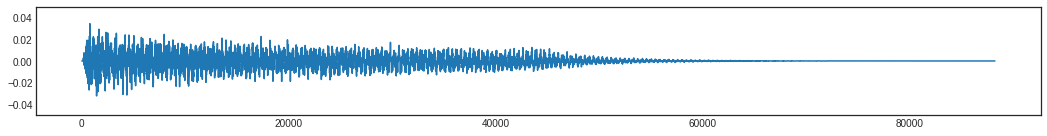

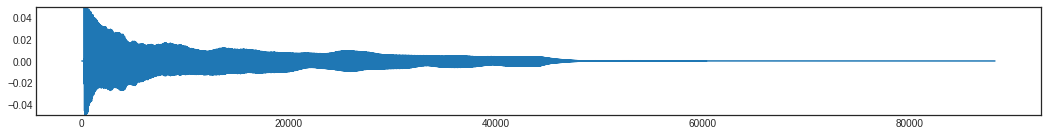

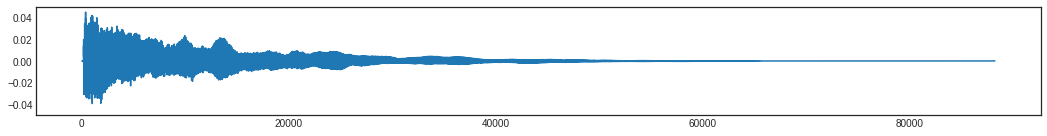

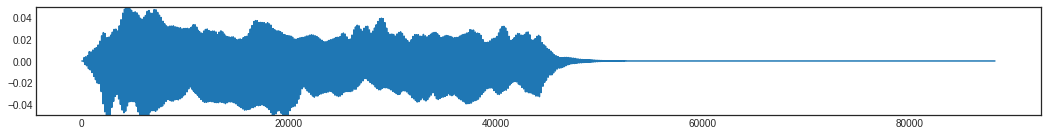

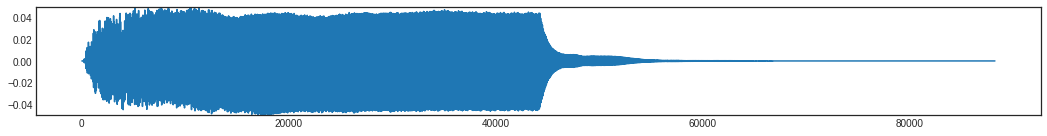

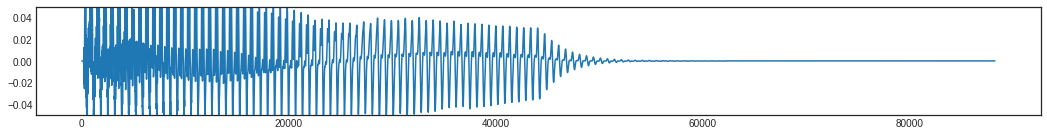

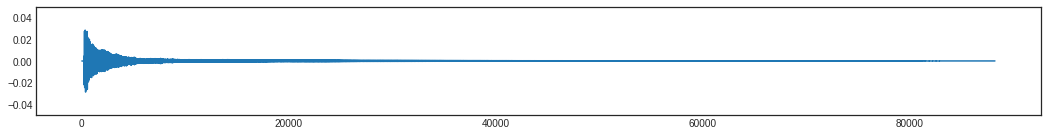

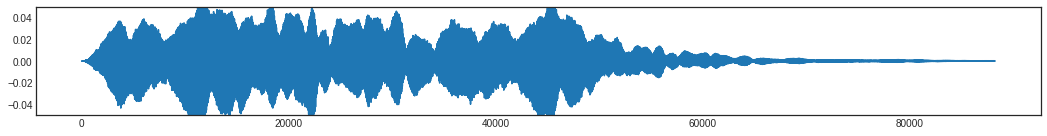

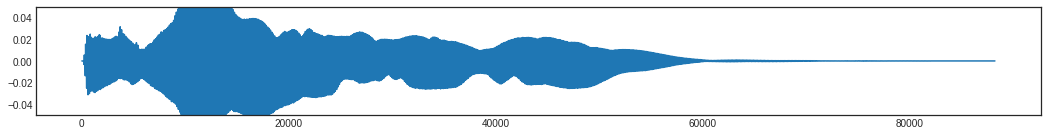

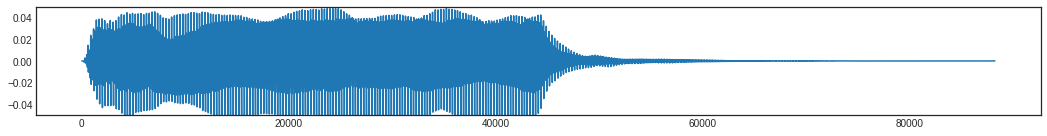

In [153]:
 #50의 stride로 10개 악기 파형을 시각화함

for idx in range(0,len(audio_np),num_notes):
  plt.figure(figsize=(18,2))
  plt.plot(audio_np[idx])
  plt.ylim(-0.05,0.05)

In [154]:
ipd.Audio(audio_np[34],rate = sr)

## 머신러닝을 이용한 오디오 분류

* 학습 데이터와 실험 데이터를 분리

In [155]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(audio_np, inst_np, test_size= 0.2)

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(400, 88200) (100, 88200) (400,) (100,)


### Logistic Regression

* Logistic Regression은 특성상 다중 분류에는 적합하지 않음

In [156]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)


0.09


### Support Vector Machine

In [157]:
from sklearn import svm
SVM = svm.SVC(kernel = 'linear')
SVM.fit(train_x, train_y)
pred = SVM.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.07


### Decision Tree

In [158]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred,test_y)
print(acc)

0.28


## sigmoid, SVM, Decision Tree 모두 성능이 bad

## Constant-Q를 이용한 머신러닝 오디오 분류

### 데이터 준비

* wav는 매 순간의 음압을 측정하여 그 수치를 저장한 형태이기 때문에 그 자체로 음악을 분석하기에 적합하지 않음 (음의 높이와 세기를 듣는것이지 순간의 음압을 듣는게 아니기 때문)
* 푸리에 변환과 같은 변환 기법을 이용하여 시간 축의 데이터를 주파수 축의 데이터로 바꿔줘야할 필요가 있음
* 푸리에 변환 대신 푸리에 변환과 유사한 Constant-Q 변환을 사용
* Constant-Q 변환은 주파수 축이 로그 단위로 변환되고, 각 주파수에 따라 해상도가 다양하게 처리되기 때문에(저주파는 저해상도, 고주파는 고해상도) 음악을 처리하는 데에 푸리에 변환보다 유리

*   주파수 대역을 저장할 리스트 `audio_cqt` 선언
*   constant-Q 변환할 때는 변환할 오디오 데이터와 sampling rate가 필요
*   해당 데이터에서는 sampling rate가 모두 동일하므로 따로 처리가 필요하지 않음
*   여기서는 Constant-Q 변환을 사용해 오디오 데이터를 주파수 대역으로 변환




*   변환에는 앞서 준비한 데이터를 가져와 사용하며, Constant-Q 변환에는 `librosa.cqt` 함수를 사용
*   여기서 `n_bins`는 옥타브 단계 및 개수를, `bins_per_octave`는 한 옥타브가 가지는 단계를 의미
*   라벨에 대해선 원 핫 인코딩을 적용



In [159]:
audio_cqt = []
for y in audio : 
  ret = librosa.cqt(y, sr,hop_length=1024, n_bins=24*7, bins_per_octave=24) # 한옥타브를 24개 구간으로 나누고, 총 24*7 개의 bin
  ret = np.abs(ret)
  audio_cqt.append(ret)



* 앞서 생성한 주파수 대역을 spectrogram으로 시각화
  - amplitude_to_db : amplitude를 db로 변환
  $$power_{dB} = 20 * log10(amp / amp_{ref})$$

* 악기 간 spectrogram을 비교해보면 차이가 존재함을 알 수 있음


/usr/local/lib/python3.7/dist-packages/librosa/display.py:1336: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  "Frequency axis exceeds Nyquist. "


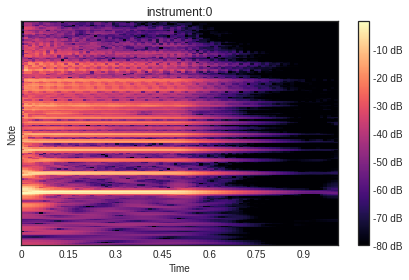

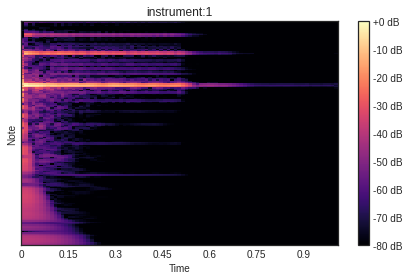

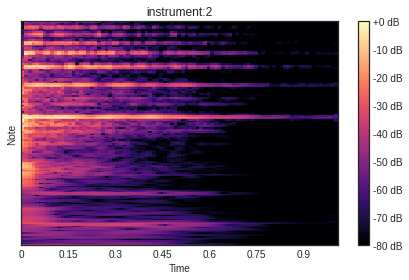

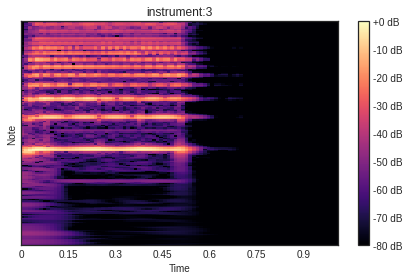

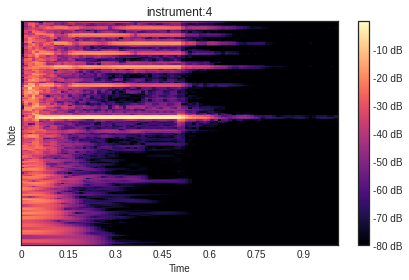

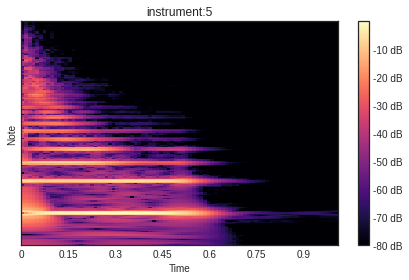

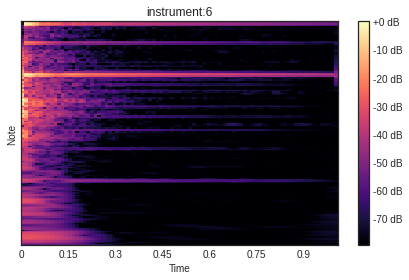

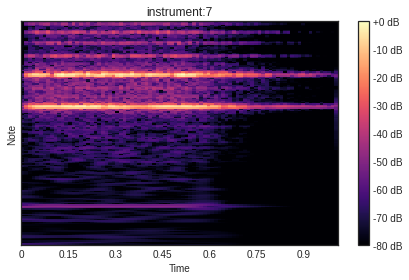

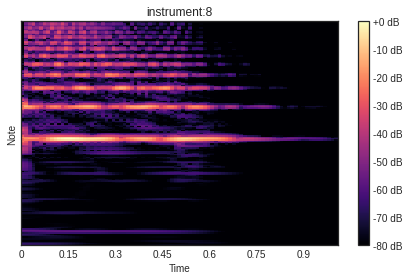

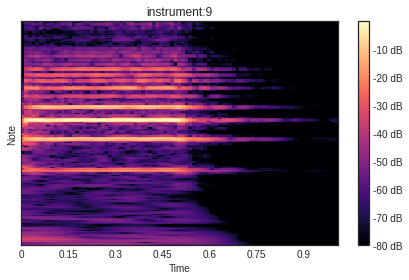

In [160]:
for i in range(0, len(instruments)*num_notes, num_notes):
  amp_db = librosa.amplitude_to_db(np.abs(audio_cqt[i]), ref=np.max) #amplitude를 dB 단위로 변환
  librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis= 'cqt_note')
  plt.colorbar(format='%+2.0f dB')
  plt.title(f'instrument:{inst[i]}')
  plt.tight_layout()
  plt.show()

* array로 변환
- `audio_cqt` -> `cqt.np`

- `inst` -> `inst_np`

In [161]:
cqt_np= np.array(audio_cqt,np.float32)
inst_np = np.array(inst, np.int16)

print(cqt_np.shape, inst_np.shape)

(500, 168, 87) (500,)


### Reshape

*   분류기에서 사용하기 위해 3차원 벡터를 2차원 벡터로 변환



In [162]:
cqt_np = cqt_np.reshape(500, 168*87)
cqt_np.shape

(500, 14616)



*   읽어온 데이터는 음량이나 범위가 다를 수 있음
*   min-max scaling을 통해 데이터의 범위를 조정함



In [163]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(cqt_np)


MinMaxScaler(copy=True, feature_range=(0, 1))

* 학습 데이터와 실험 데이터를 분리

In [164]:
train_x, test_x, train_y, test_y = train_test_split(cqt_np, inst_np, test_size= 0.2)

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(400, 14616) (100, 14616) (400,) (100,)


### Logistic Regression

In [165]:
LR = LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)


0.34


### Support Vector Machine

In [166]:
SVM = svm.SVC(kernel = 'linear')
SVM.fit(train_x, train_y)
pred = SVM.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.44


### Decision Tree

In [167]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred,test_y)
print(acc)

0.6


### Constant-Q 로 linear한 모델로 학습시킨 결과, 개선되었음
 

## Constant-Q 특징을 이용한 딥러닝 오디오 분류

* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성
* 이 spectrogram을 CNN 이미지 분류를 통해 각 악기 소리를 분류

### DNN 모델 구성 
  - label을 one-hot encoding
  - train , test 분리

In [168]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

cqt_array = np.expand_dims(cqt_np,-1) #(500, 14616) -> (500, 14616, 1) 로 차원 확장 
inst_cat = to_categorical(inst_np)  # instrument index one-hot encoding

print(cqt_array.shape, inst_cat.shape)

train_x, test_x, train_y, test_y = train_test_split(cqt_array,inst_cat,test_size=0.2)

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) 

(500, 14616, 1) (500, 10)
(400, 14616, 1) (100, 14616, 1) (400, 10) (100, 10)


In [169]:
from keras.models import Model
from keras.layers import Dense, Input
from tensorflow import keras

def model_build(input_shape):
  #model = Sequential()
  input = Input(shape=input_shape,name='input')
  x = Dense(512, activation = 'relu', name = 'hidden1')(input)
  x = Dense(256, activation = 'relu', name = 'hidden2')(x)
  x = Dense(128, activation = 'relu', name = 'hidden3')(x)
  output = Dense(10, activation = 'softmax', name = 'output')(x)

  model= Model(inputs= [input], outputs = output)

  model.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['acc']
  )
  
  return model

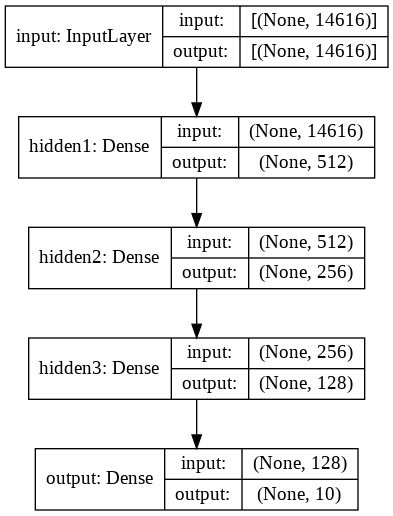

In [170]:
model = model_build((14616,))
keras.utils.plot_model(model, "DNN.png", show_shapes=True)
#model.summary()

In [171]:
from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint_path = 'my_checkpoint.ckpt'
# checkpoint= ModelCheckpoint(filepath = checkpoint_path,
#                             save_weights_only = True,
#                             save_best_only = True,
#                             monitor= 'val_loss',
#                             verbose=1
#                             ) 
history = model.fit(train_x,train_y, batch_size=128, epochs= 30, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 1s 142ms/step - loss: 2.2647 - acc: 0.1344 - val_loss: 2.0837 - val_acc: 0.3000
Epoch 2/30
3/3 [==============================] - 0s 29ms/step - loss: 1.8973 - acc: 0.4187 - val_loss: 1.9468 - val_acc: 0.3125
Epoch 3/30
3/3 [==============================] - 0s 24ms/step - loss: 1.5387 - acc: 0.5000 - val_loss: 1.8818 - val_acc: 0.3250
Epoch 4/30
3/3 [==============================] - 0s 26ms/step - loss: 1.2477 - acc: 0.6281 - val_loss: 1.9649 - val_acc: 0.3750
Epoch 5/30
3/3 [==============================] - 0s 24ms/step - loss: 0.9771 - acc: 0.7219 - val_loss: 2.1245 - val_acc: 0.3750
Epoch 6/30
3/3 [==============================] - 0s 27ms/step - loss: 0.7972 - acc: 0.7688 - val_loss: 2.3809 - val_acc: 0.3500
Epoch 7/30
3/3 [==============================] - 0s 24ms/step - loss: 0.6283 - acc: 0.8406 - val_loss: 2.4992 - val_acc: 0.4000
Epoch 8/30
3/3 [==============================] - 0s 24ms/step - loss: 0.5340 - acc: 0.8844 - va

In [172]:
def loss_and_acc(hist):
  plt.figure(figsize=(12,4))
  plt.subplot(121)

  plt.plot(hist.history['val_acc'], label= 'val_acc')
  plt.plot(hist.history['acc'], label = 'acc')
  plt.xlabel('epochs')
  plt.title('acc')
  plt.legend()
  plt.subplot(122)
  plt.plot(hist.history['val_loss'], label= 'val_loss')
  plt.plot(hist.history['loss'], label = 'loss')
  plt.xlabel('epochs')
  plt.title('val_loss')
  plt.legend()
  plt.show()

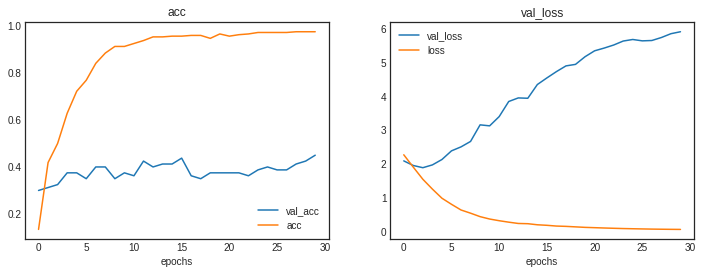

In [173]:
loss_and_acc(history)

### 심각한 Overfitting이 일어났다.

In [174]:
model.evaluate(test_x, test_y)

4/4 [==============================] - 0s 5ms/step - loss: 5.4049 - acc: 0.4200


[5.404852390289307, 0.41999998688697815]

### CNN 모델 구성



*   spectrogram을 분류할 CNN 모델 구성
*   모델의 구성은 여타 이미지 분류 모델과 다르지 않음
*   spectrogram은 1차원 이미지로 간주 -> reshape 하지 않음


In [175]:
#그대로 할당 

cqt_array = np.array(audio_cqt, np.float32)
 
inst_cat = to_categorical(inst_np)  # instrument index one-hot encoding

print(cqt_array.shape, inst_cat.shape)

train_x, test_x, train_y, test_y = train_test_split(cqt_array,inst_cat,test_size=0.2)

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) 

(500, 168, 87) (500, 10)
(400, 168, 87) (100, 168, 87) (400, 10) (100, 10)


In [176]:
from keras.layers import Conv2D, Flatten, MaxPool2D
def model_build2(input_shape):
  input = Input(shape= input_shape)

  x = Conv2D(128,3, padding='same', activation='relu')(input)
  x = MaxPool2D(pool_size=(2,2), strides = 2, padding='same')(x) 
  
  x = Conv2D(256,3, padding='same', activation='relu')(x)
  x = MaxPool2D(pool_size=(2,2), strides = 2, padding='same')(x) 
  
  x = Conv2D(512,3, padding='same', activation='relu')(x)
  x = MaxPool2D(pool_size=(2,2), strides = 2, padding='same')(x) 

  x = Flatten()(x)
  x = Dense(512, activation='relu')(x)
  x = Dense(128, activation='relu')(x)
  x = Dense(64, activation='relu')(x)
  output = Dense(10, activation = 'softmax')(x)

  model = Model(inputs = [input], outputs= output)

  model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics=['acc'] )
  return model


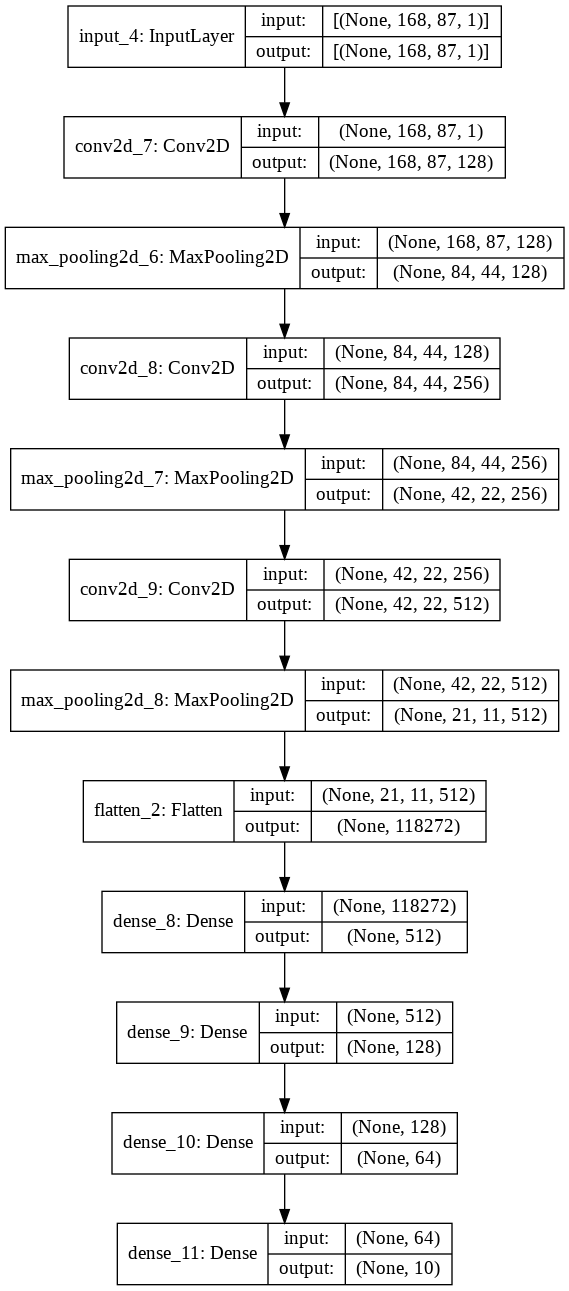

In [177]:
model2 = model_build2((train_x.shape[1],train_x.shape[2],1))
keras.utils.plot_model(model2, show_shapes=True, show_layer_names=True)

In [178]:
history = model2.fit(train_x, train_y, epochs=20, batch_size=20, validation_split=0.2)


Epoch 1/20
16/16 [==============================] - 4s 177ms/step - loss: 2.0386 - acc: 0.2562 - val_loss: 1.8121 - val_acc: 0.3250
Epoch 2/20
16/16 [==============================] - 2s 157ms/step - loss: 1.3150 - acc: 0.5250 - val_loss: 1.4540 - val_acc: 0.4375
Epoch 3/20
16/16 [==============================] - 3s 158ms/step - loss: 1.0230 - acc: 0.6000 - val_loss: 1.2079 - val_acc: 0.5750
Epoch 4/20
16/16 [==============================] - 3s 159ms/step - loss: 0.6410 - acc: 0.7844 - val_loss: 1.3280 - val_acc: 0.5750
Epoch 5/20
16/16 [==============================] - 3s 158ms/step - loss: 0.5136 - acc: 0.8156 - val_loss: 0.5379 - val_acc: 0.7625
Epoch 6/20
16/16 [==============================] - 2s 157ms/step - loss: 0.3974 - acc: 0.8844 - val_loss: 1.1682 - val_acc: 0.5625
Epoch 7/20
16/16 [==============================] - 2s 157ms/step - loss: 0.3797 - acc: 0.8875 - val_loss: 0.5772 - val_acc: 0.7500
Epoch 8/20
16/16 [==============================] - 2s 156ms/step - loss: 0.

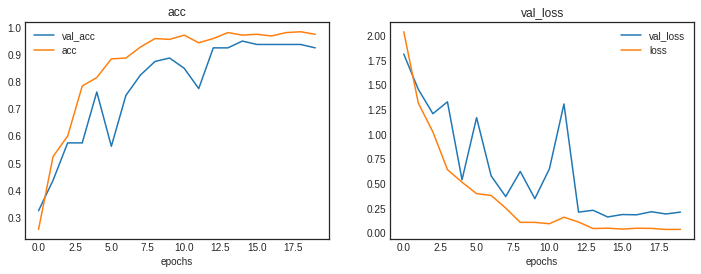

In [179]:
loss_and_acc(history)



*   훈련한 모델에 대한 정확도 평가
*   앞선 일반 분류 방법보다 정확도가 많이 오른 것을 확인할 수 있음
### accuracy 94%


In [180]:
model2.evaluate(test_x, test_y)

4/4 [==============================] - 0s 61ms/step - loss: 0.2143 - acc: 0.9500


[0.21429437398910522, 0.949999988079071]

## MFCC를 이용한 머신러닝 오디오 분류

### 데이터 준비

* 데이터를 불러오고 MFCC(Mel-frequency cepstral coefficients)를 사용해 melspectrogram으로 변환

In [181]:
audio_mfcc = []
for y in audio : 
  #mfcc() method 소환
  ret = librosa.feature.mfcc(y=y, sr = sr)
  audio_mfcc.append(ret)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9839 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9839 missing from current font.
  font.set_text(s, 0, flags=flags)


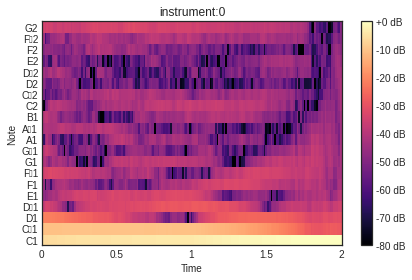

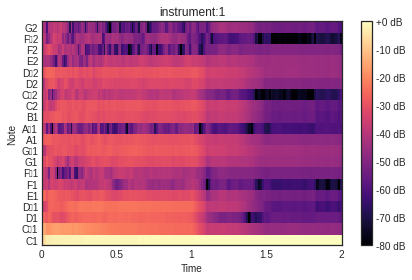

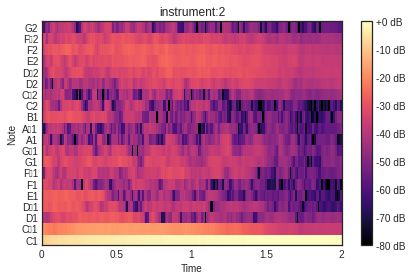

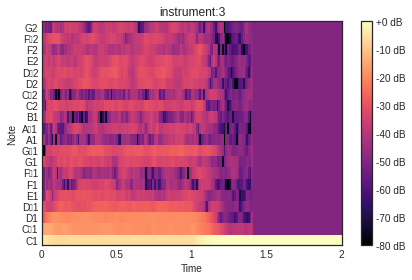

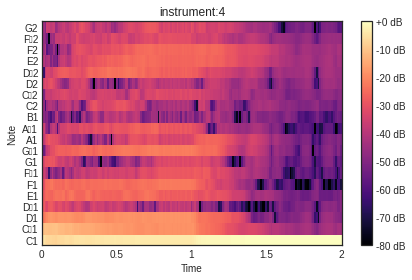

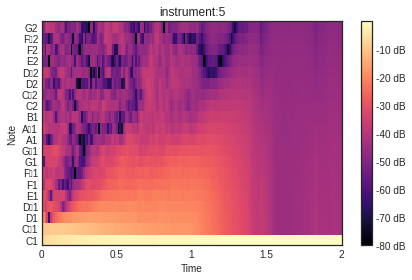

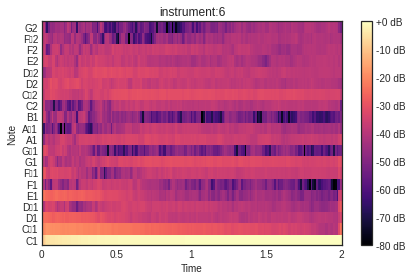

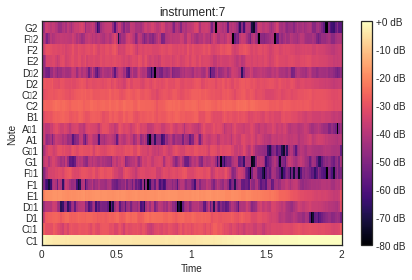

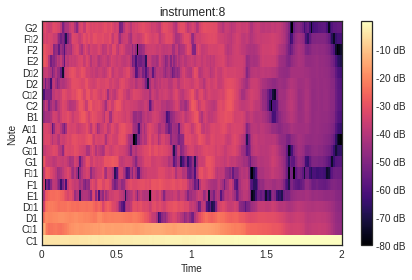

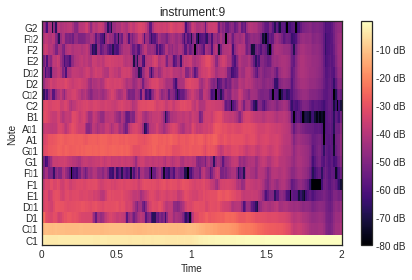

In [182]:
for i in range(0, len(instruments)*num_notes, num_notes):
  amp_db = librosa.amplitude_to_db(np.abs(audio_mfcc[i]), ref=np.max) #amplitude를 dB 단위로 변환
  librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis= 'cqt_note')
  plt.colorbar(format='%+2.0f dB')
  plt.title(f'instrument:{inst[i]}')
  plt.tight_layout()
  plt.show()

In [183]:
mfcc_np = np.array(audio_mfcc, dtype=np.float32)
inst_np = np.array(inst, np.int16)

print(mfcc_np.shape, inst_np.shape)

(500, 20, 173) (500,)




*   분류기에서 사용하기 위해 3차원 벡터를 2차원 벡터로 변환



In [184]:
mfcc_np = mfcc_np.reshape((500,20*173))
mfcc_np.shape

(500, 3460)



*   읽어온 데이터는 음량이나 범위가 다를 수 있음
*   min-max scaling을 통해 데이터의 범위를 조정함



In [185]:
MinMaxScaler().fit(mfcc_np)

MinMaxScaler(copy=True, feature_range=(0, 1))

* 학습 데이터와 실험 데이터를 분리

In [186]:
# 데이터가 3460개로 줄어든 것을 확인할 수 있음
train_x, test_x, train_y, test_y = train_test_split(mfcc_np,inst_np,test_size=0.2)

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) 

(400, 3460) (100, 3460) (400,) (100,)


### Logistic Regression

In [187]:
LR = LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)


0.96


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Support Vector Machine

In [188]:
SVM = svm.SVC(kernel = 'linear')
SVM.fit(train_x, train_y)
pred = SVM.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.96


### Decision Tree

In [189]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred,test_y)
print(acc)

0.86


## MFCC를 이용한 딥러닝 오디오 분류

* 앞선 문제점을 극복하기 위해 오디오 데이터에 특화된 분류 방법 필요
* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성
* 이 spectrogram을 CNN 이미지 분류를 통해 각 악기 소리를 분류

### DNN 모델 구성

In [190]:
mfcc_array = np.expand_dims(mfcc_np,-1) #(500, 14616) -> (500, 14616, 1) 로 차원 확장 
inst_cat = to_categorical(inst_np)  # instrument index one-hot encoding

print(mfcc_array.shape, inst_cat.shape)
train_x, test_x, train_y, test_y = train_test_split(mfcc_array,inst_cat,test_size=0.2)

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(500, 3460, 1) (500, 10)
(400, 3460, 1) (100, 3460, 1) (400, 10) (100, 10)


In [191]:
def model_build(input_shape):
  #model = Sequential()
  input = Input(shape=input_shape,name='input')
  x = Dense(512, activation = 'relu', name = 'hidden1')(input)
  x = Dense(256, activation = 'relu', name = 'hidden2')(x)
  x = Dense(128, activation = 'relu', name = 'hidden3')(x)
  output = Dense(10, activation = 'softmax', name = 'output')(x)

  model= Model(inputs= [input], outputs = output)

  model.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['acc']
  )
  
  return model

In [192]:
dim =train_x.shape[1]
print(dim)
model3 = model_build(input_shape=(dim,))
model3.summary()

3460
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3460)]            0         
_________________________________________________________________
hidden1 (Dense)              (None, 512)               1772032   
_________________________________________________________________
hidden2 (Dense)              (None, 256)               131328    
_________________________________________________________________
hidden3 (Dense)              (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,937,546
Trainable params: 1,937,546
Non-trainable params: 0
_________________________________________________________________


In [193]:
history = model3.fit(train_x,train_y,batch_size = 128, epochs=20, validation_split=0.2)

Epoch 1/20
3/3 [==============================] - 1s 130ms/step - loss: 257.5827 - acc: 0.0906 - val_loss: 188.0493 - val_acc: 0.2375
Epoch 2/20
3/3 [==============================] - 0s 21ms/step - loss: 220.0488 - acc: 0.1656 - val_loss: 303.9238 - val_acc: 0.2000
Epoch 3/20
3/3 [==============================] - 0s 20ms/step - loss: 287.4828 - acc: 0.1656 - val_loss: 169.5010 - val_acc: 0.2625
Epoch 4/20
3/3 [==============================] - 0s 17ms/step - loss: 146.1660 - acc: 0.1719 - val_loss: 62.7181 - val_acc: 0.2500
Epoch 5/20
3/3 [==============================] - 0s 27ms/step - loss: 69.7082 - acc: 0.2844 - val_loss: 42.4946 - val_acc: 0.2750
Epoch 6/20
3/3 [==============================] - 0s 18ms/step - loss: 42.4692 - acc: 0.3156 - val_loss: 37.9370 - val_acc: 0.3875
Epoch 7/20
3/3 [==============================] - 0s 19ms/step - loss: 35.1735 - acc: 0.4062 - val_loss: 43.9312 - val_acc: 0.3500
Epoch 8/20
3/3 [==============================] - 0s 17ms/step - loss: 24.4

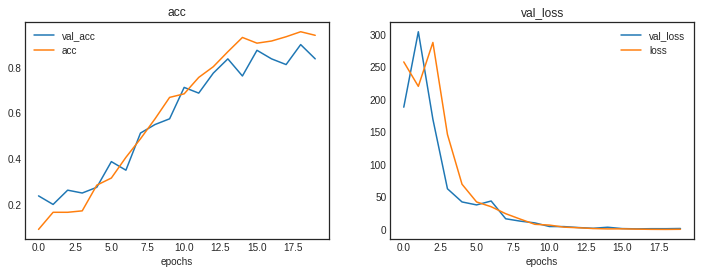

In [194]:
loss_and_acc(history)

In [195]:
model3.evaluate(test_x,test_y)

4/4 [==============================] - 0s 4ms/step - loss: 2.7688 - acc: 0.8000


[2.768829584121704, 0.800000011920929]

### CNN 모델 구성

In [196]:
#그대로 할당 

mfcc_array = np.array(audio_mfcc, dtype=np.float32)
inst_np = np.array(inst, np.int16)

print(mfcc_np.shape, inst_np.shape)


 
inst_cat = to_categorical(inst_np)  # instrument index one-hot encoding

print(mfcc_array.shape, inst_cat.shape)

train_x, test_x, train_y, test_y = train_test_split(mfcc_array,inst_cat,test_size=0.2)

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) 

(500, 3460) (500,)
(500, 20, 173) (500, 10)
(400, 20, 173) (100, 20, 173) (400, 10) (100, 10)




*   spectrogram을 분류할 CNN 모델 구성
*   모델의 구성은 여타 이미지 분류 모델과 다르지 않음
*   spectrogram은 1차원 이미지로 간주


In [197]:
input_shape = (train_x.shape[1],train_x.shape[2],1)
model4 = model_build2(input_shape)
model4.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 20, 173, 1)]      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 20, 173, 128)      1280      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 10, 87, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 87, 256)       295168    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 44, 256)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 44, 512)        1180160   
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 22, 512)        0  

In [198]:
history = model4.fit(train_x,train_y,batch_size = 128, epochs=20, validation_split=0.2)

Epoch 1/20
3/3 [==============================] - 2s 293ms/step - loss: 106.4401 - acc: 0.1250 - val_loss: 23.1792 - val_acc: 0.1625
Epoch 2/20
3/3 [==============================] - 1s 168ms/step - loss: 18.7114 - acc: 0.0969 - val_loss: 3.8023 - val_acc: 0.1250
Epoch 3/20
3/3 [==============================] - 1s 169ms/step - loss: 3.1588 - acc: 0.1312 - val_loss: 2.3921 - val_acc: 0.0500
Epoch 4/20
3/3 [==============================] - 1s 170ms/step - loss: 2.2801 - acc: 0.1969 - val_loss: 2.1767 - val_acc: 0.2375
Epoch 5/20
3/3 [==============================] - 1s 167ms/step - loss: 2.0626 - acc: 0.2781 - val_loss: 1.9842 - val_acc: 0.1375
Epoch 6/20
3/3 [==============================] - 1s 171ms/step - loss: 1.8160 - acc: 0.3594 - val_loss: 1.8170 - val_acc: 0.4125
Epoch 7/20
3/3 [==============================] - 1s 170ms/step - loss: 1.6931 - acc: 0.3844 - val_loss: 1.3882 - val_acc: 0.4000
Epoch 8/20
3/3 [==============================] - 1s 174ms/step - loss: 1.2581 - acc: 

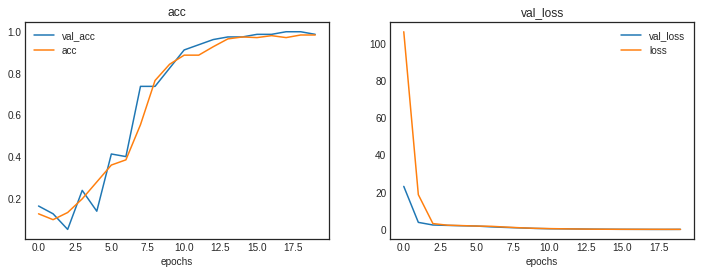

In [199]:
loss_and_acc(history)

In [200]:
model4.evaluate(test_x,test_y)

4/4 [==============================] - 0s 16ms/step - loss: 0.0408 - acc: 0.9900


[0.040801458060741425, 0.9900000095367432]

# 정리
- DNN 보다는 원래 shape를 유지한 CNN이 결과에 더 좋다.
- mfcc 를 이용하여 CNN으로 분석하면 매우 결과가 잘 나온다(98%)